Show AWS versus a model grid
===
Show each AWS site on a map at scale comparable to model gridpoints such that the AWS context within the model grid can be visualized.

The code is currently setup to use CESM LE lat/lon data but could use any model grid.  The main considerations when changing model grids are (probably):
- access to the data from the run directory
- dealing with 2-d coordinate files (currently setup for 1-d lat/lon and this might actually get simpler with 2-d)
- spacing of meridians and parallels could be changed with grid spacing

Global Setup
---
Setup inline plotting and import required modules.

In [1]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight'}

from netCDF4 import Dataset
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid
import numpy as np
from model import Model
from GCNet import GCNet
import math

Set domain
------
Set lat/lon boundaries based on NCL plots

In [2]:
minLon = -70 + 360
maxLon = -15 + 360
minLat = 58
maxLat = 86.5

midLat = (minLat + maxLat) / 2
midLon = (minLon  +maxLon) / 2

print "Latitudes", minLat,minLat,maxLat
print "Longitudes", minLon,midLon,maxLon

Latitudes 58 58 86.5
Longitudes 290 317 345


Read and process CESM LE data: lat, lon, elev
----
First, read model vars and create lat/lon vector

In [3]:
M = Model("cesmle_geog.nc")
M.read()
# M.info()
# dir(M)
lat2d = M.getLat2d()
lon2d = M.getLon2d()
npts  = M.getNPts()
dy = M.getDY()
dx = M.getDX()
print "Model grid spacing (degrees): %0.2f, %0.2f" % (dy, dx)

latv = lat2d.reshape( npts )
lonv = lon2d.reshape( npts )
latlon = np.column_stack( (latv,lonv ))
# print latlon.shape

Model grid spacing (degrees): 0.94, 1.25


Second, subset lat,lon to Greenland map domain (primarily for plotting purposes).

In [4]:
id = np.where((latlon[:,0]>minLat) & (latlon[:,0]<maxLat) & \
              (latlon[:,1]>minLon) & (latlon[:,1]<maxLon))[0]
print len(id), "points in subset area"
gLat = latlon[id,0]
gLon = latlon[id,1]

1290 points in subset area


AWS data
-----
Now setup AWS site info and select a specific site (zero-indexed).

In [5]:
A = GCNet("site_info.nc")
A.loadMeta()
nSites = A.getNSites()

Panel of detailed site maps
====

1 Swiss Camp 69.5732 310.7048 1149.0
2 Crawford Point1 69.8819 313.0264 2022.0
3 NASA-U 73.8333 310.5047 2368.0
4 GITS 77.1433 298.905 1887.0
5 Humboldt 78.5266 303.1695 1995.0
6 Summit 72.5794 321.4958 3208.0
7 Tunu-N 78.0168 326.0061 2020.0
8 DYE-2 66.481 313.72 2165.0
9 JAR1 69.4984 310.3184 962.0
10 Saddle 66.0006 315.4986 2559.0
11 South Dome 63.1489 315.1833 2922.0
12 NASA-E 75.0 330.0003 2631.0
13 Crawford Point2 69.9133 313.1453 1990.0
14 NGRIP 75.0998 317.6674 2950.0
15 NASA-SE 66.4797 317.49982 2579.0
16 KAR 69.6995 327.00018 2400.0
17 JAR2 69.42 309.9425 568.0
18 KULU 65.7584 320.3982 878.0
19 JAR3 69.3954 309.6896 323.0
20 Aurora 67.1352 312.7089 1798.0
21 Petermann GL 80.6836 299.7069 37.0
22 Petermann ELA 80.0831 301.9272 965.0
23 NEEM 77.5022 309.1256 2454.0


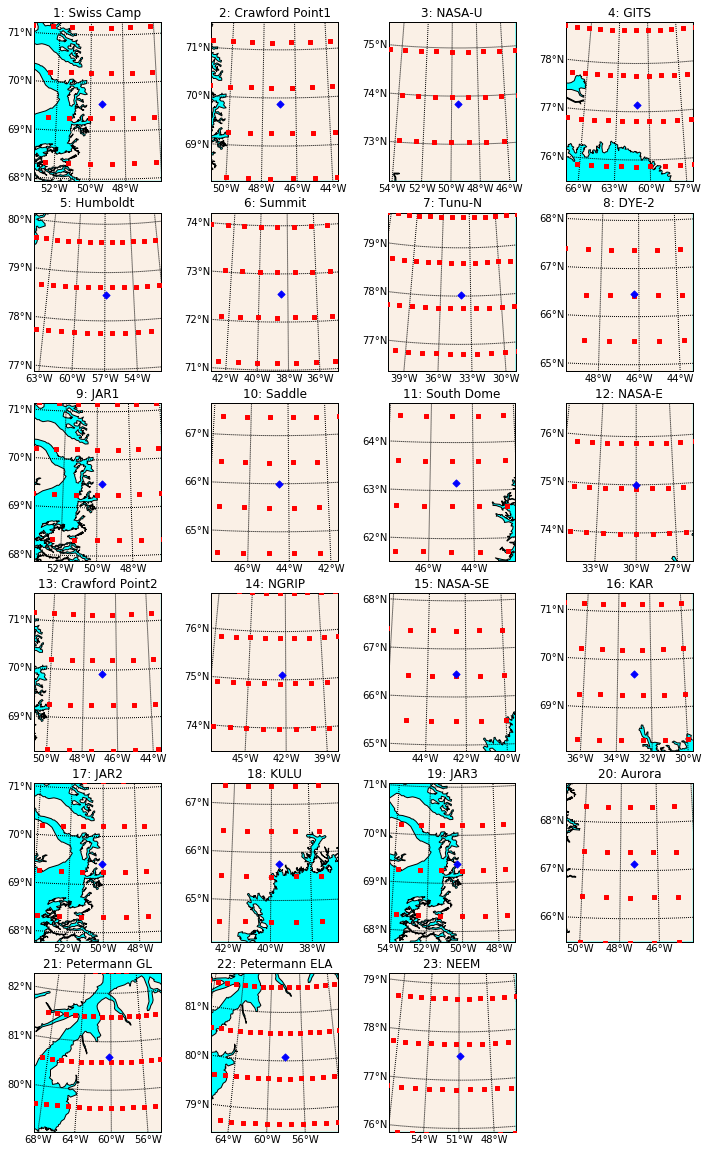

In [62]:
fig3, axes = plt.subplots(nrows=6, ncols=4, figsize=(10,16))
plt.tight_layout()
axesF = axes.flat
fig3.delaxes(axesF[-1])
for Q in (zip(range(nSites),axesF)):
    awsIX = Q[0]
    axCurr = Q[1]
    awsStr = str(awsIX+1)

    siteLat = A.getLat( awsIX )
    siteLon = A.getLon( awsIX )
    siteElev = A.getElev( awsIX )
    siteName = A.getName( awsIX ).replace('_',' ')
    print awsStr, siteName, siteLat, siteLon, siteElev

    # map based on dLat,dLon
    # favor (approximately) square map over equal n/s & e/w distances
    yRange = dy * 3.5
    dLat = yRange / 2
    wtLon = math.cos( math.radians(siteLat) )
    nLon = yRange / (dx * wtLon )
    dLon = nLon / 2

    mLcl = Basemap(projection='stere', \
                   llcrnrlon = siteLon - dLon, llcrnrlat = siteLat - dLat, \
                   urcrnrlon = siteLon + dLon, urcrnrlat = siteLat + dLat, \
                   lat_ts=siteLat, lat_0=siteLat, lon_0=siteLon, resolution='i', \
                   ax=axCurr)
    mLcl.drawcoastlines()
    # labels = [left,right,top,bottom]
    labels=[True,False,False,False]
    mLcl.drawparallels(np.arange(0.,90.,1.),latmax=90,labels=labels)
    labels=[False,False,False,True]
    lonSpacing = 2
    if siteLat >= 74:
        lonSpacing = 3
    if siteLat >= 80:
        lonSpacing = 4
    mLcl.drawmeridians(np.arange(-180.,181.,lonSpacing),latmax=90,labels=labels)
    mLcl.drawmapboundary(fill_color='aqua')
    mLcl.fillcontinents(color='linen',lake_color='aqua')

    x1,y1 = mLcl(siteLon,siteLat)
    mLcl.scatter( x1, y1, s=25, marker='D', color='b', zorder=5)

    x2,y2 = mLcl(gLon,gLat)
    mLcl.scatter( x2, y2, s=12, marker='s', color='r', zorder=4)

    axCurr.set_title(awsStr+": "+siteName, fontsize=12)

#     # not sure map scale is really worth the effort to look nice in all situations
#     latScale = 0.12
#     lonScale = 0.5
#     if awsIX in (3,5,6,13,14,15):
#         latScale = 0.8
#     if awsIX in (16,17,18):        
#         lonScale = 0.75
#     if awsIX == 8:
#         latScale = 0.2
#         lonScale = 0.75
      
#     sLat = (mLcl.urcrnrlat - mLcl.llcrnrlat) * latScale + mLcl.llcrnrlat
#     sLon = (mLcl.urcrnrlon - mLcl.llcrnrlon) * lonScale + mLcl.llcrnrlon
#     mLcl.drawmapscale(lon=sLon, lat=sLat, lon0=siteLon, lat0=siteLat, length=100, \
#                       barstyle='fancy', fillcolor2='gray', zorder=6)
    
# plt.show()
plt.savefig('aws_cesm_site_maps.eps',dpi=fig3.dpi,papertype='a3')

#     print "Model grid spacing (degrees): %0.2f, %0.2f" % (dy, dx)